In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


# Utilitzant un Model Existent

Se ha decidit utilitzar el model Resnet50 després de mirar la comparació de models de classificació d'imatges al següent [enllaç](https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/).

A continuació carregam les imatges del dataset per poder utilitzarles.

## Càrrega de Dades

Càlcul de la mitjana i desviació típica per a poder transformar les dades.

In [4]:
data_dir = './data/'
model_dir = './models/'
input_size = 224 # Tamany d'imatge que utiliza Resnet
batch_size = 32

In [5]:
# transform = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor()
#     ])

# # dataset = datasets.ImageNet(".", split="train", transform=transform)
# dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)

# means = []
# stds = []
# for img, label in dataset:
#     means.append(torch.mean(img))
#     stds.append(torch.std(img))

# mean = torch.mean(torch.tensor(means))
# std = torch.mean(torch.tensor(stds))
# print(f'{mean=}, {std=}')

In [6]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5098), (0.2212)) # mitjana, desviacio tipica
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5098), (0.2212)) # mitjana, desviacio tipica
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


## Funcions Auxiliars

In [7]:
def init_model(num_classes, feature_extract, weights=None):
    model = models.resnet50(weights=weights)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

In [8]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, filename=None):
    since = time.time()
    tra_acc_history = []
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                tra_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if filename != None:
        torch.save(model.state_dict(), os.path.join(model_dir, filename))
    return model, tra_acc_history, val_acc_history

## Model Preentrenat

En aquest apartat provam l'arquitectura del model Resnet50 utilitzant els pesos preentrenats amb el dataset ImageNet.

Només modificam els valors de la darrera capa per a que faci una classificació binaria ja que només tenim 2 labels.

### Define Model

In [9]:
model = init_model(num_classes=2, feature_extract=True, weights=models.ResNet50_Weights.DEFAULT)
model = model.to(device)

In [10]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Params to be trained: {params}')

Params to be trained: 4098


### Train Model

In [13]:
num_epochs = 15

# Gather the parameters to be optimized/updated in this run. We are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = [param for name, param in model.named_parameters() if param.requires_grad == True]
print("Params to learn: ", [param for param in params_to_update])

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, pt_tra_acc, pt_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, filename='pretrained.pt')

Params to learn:  [Parameter containing:
tensor([[-0.0266, -0.0003, -0.0267,  ..., -0.0292, -0.0035,  0.0465],
        [ 0.0419, -0.0106,  0.0138,  ...,  0.0045,  0.0203, -0.0303]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0093, -0.0330], device='cuda:0', requires_grad=True)]
Epoch 0/14
----------
train Loss: 0.0676 Acc: 0.9873


KeyboardInterrupt: 

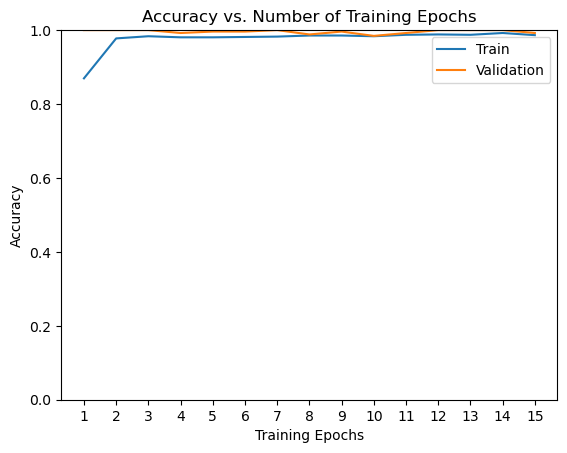

In [10]:
train = [h.cpu().numpy() for h in pt_tra_acc]
val = [h.cpu().numpy() for h in pt_val_acc]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train,label="Train")
plt.plot(range(1,num_epochs+1),val,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Model Reentrenat

In [11]:
model = init_model(num_classes=2, feature_extract=False, weights=None)
model = model.to(device)

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Params to be trained: {params}')

Params to be trained: 23512130


In [13]:
num_epochs = 15

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, t_tra_acc, t_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, filename='retrained.pt')

Epoch 0/14
----------
train Loss: 0.7228 Acc: 0.5560
val Loss: 14.9559 Acc: 0.5000

Epoch 1/14
----------
train Loss: 0.7349 Acc: 0.5881
val Loss: 20.7547 Acc: 0.5000

Epoch 2/14
----------
train Loss: 0.7266 Acc: 0.5784
val Loss: 4.2855 Acc: 0.5000

Epoch 3/14
----------
train Loss: 0.5984 Acc: 0.6748
val Loss: 4.8462 Acc: 0.5000

Epoch 4/14
----------
train Loss: 0.5984 Acc: 0.6845
val Loss: 1.9217 Acc: 0.6367

Epoch 5/14
----------
train Loss: 0.5535 Acc: 0.7225
val Loss: 0.6609 Acc: 0.7109

Epoch 6/14
----------
train Loss: 0.5471 Acc: 0.7313
val Loss: 0.4180 Acc: 0.8359

Epoch 7/14
----------
train Loss: 0.5957 Acc: 0.7147
val Loss: 5.6342 Acc: 0.5000

Epoch 8/14
----------
train Loss: 0.6064 Acc: 0.7283
val Loss: 5.4101 Acc: 0.5000

Epoch 9/14
----------
train Loss: 0.4281 Acc: 0.8101
val Loss: 0.8013 Acc: 0.6484

Epoch 10/14
----------
train Loss: 0.4262 Acc: 0.8150
val Loss: 1.9258 Acc: 0.6094

Epoch 11/14
----------
train Loss: 0.4915 Acc: 0.7858
val Loss: 0.7483 Acc: 0.6562



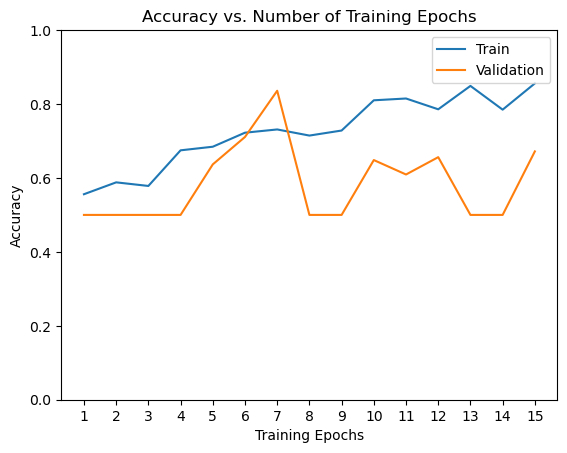

In [14]:
train = [h.cpu().numpy() for h in t_tra_acc]
val = [h.cpu().numpy() for h in t_val_acc]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),train,label="Train")
plt.plot(range(1,num_epochs+1),val,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Com podem veure la accuracy durant la validació es molt menor que la de l'entrenament. Aixó pot ser ja que el model senser es massa complex per a la poca cantidad d'imatges que tenim. En canvi amb els pesos del ImageNet al tenir moltes mes imatges pot separar molt mes facilment les caracteristiques de les imatges i després fent un reentrament de la detecció de les features que ens interesen podem obtenir un resultat molt millor.

## Comparació

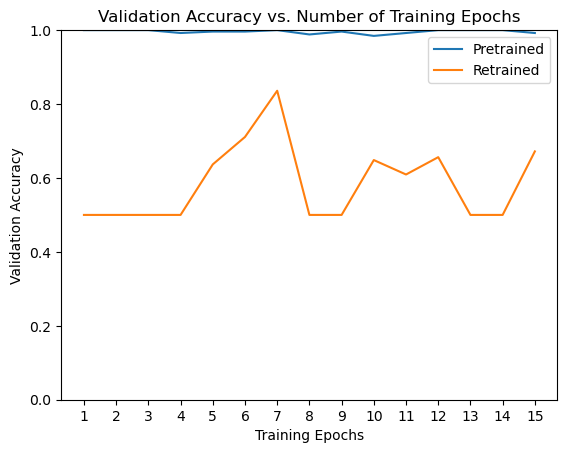

In [15]:
pretrained = [h.cpu().numpy() for h in pt_val_acc]
retrained = [h.cpu().numpy() for h in t_val_acc]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),pretrained,label="Pretrained")
plt.plot(range(1,num_epochs+1),retrained,label="Retrained")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Com podem observar s'obté un molt millor resultat utilitzant els pesos preentrenats.